In [26]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
def get_unique_words(text):
    words = [word for message in text for word in message]
    return set(words)

def co_occurence_matrix_with_window(text, window_size, stop_words):
    unique_words = get_unique_words(text)
    n = len(unique_words) #number of unique words
    co_matrix = pd.DataFrame(data=np.zeros([n,n]), columns=unique_words, index=unique_words, dtype='int')

    
    for message in text:
        msg_len = len(message)
        for i, word in enumerate(message):
            first = max(i - window_size, 0)
            last = min(i + window_size + 1, msg_len)
            for context in message[first:last]:
                co_matrix.loc[word,context] += 1
    return co_matrix  
    
def co_occurence_matrix(text, target=None, stop_words=None):  
    preprocessor = CountVectorizer(strip_accents='unicode').build_preprocessor()
    stop_words = [preprocessor(word) for word in stop_words] #preprocesses stop words
    if target:
        target = preprocessor(target) #preprocesses target word
        text = text[text.str.contains(target)] #Filter comments in which target word is present
        
    #calculates word count for each message
    vectorizer = CountVectorizer(strip_accents='unicode', stop_words=stop_words, binary=True)
    X = vectorizer.fit_transform(text).toarray()
    
    labels = vectorizer.get_feature_names()
    
    return X, labels

In [3]:
data = pd.read_csv('../comments.csv', usecols=['text'])['text'].dropna()
stop_words = [word.rstrip() for word in open('stopwords.txt')]

In [10]:
X, labels = co_occurence_matrix(data, 'virus', stop_words=stop_words)

comments_count = X.sum(axis=0) #no. of comments containing A in which each word appears
comments_count = sorted(zip(labels, comments_count), reverse=True, key=lambda tupl : tupl[1])
print('30 palavras que mais ocorrem nos mesmos comentários em que "vírus" ocorre:')
print(comments_count[:30])

Palavras que mais ocorrem nos mesmos comentários em que "vírus" ocorre:
[('virus', 1017), ('coronavirus', 638), ('pessoas', 307), ('pra', 222), ('pode', 220), ('vai', 195), ('corona', 189), ('ainda', 179), ('sobre', 160), ('atila', 143), ('agora', 140), ('brasil', 136), ('casa', 133), ('aqui', 118), ('todos', 117), ('video', 114), ('vc', 113), ('sintomas', 112), ('sim', 110), ('pois', 108), ('fazer', 107), ('gente', 107), ('bem', 106), ('ai', 104), ('gripe', 104), ('doenca', 102), ('entao', 102), ('todo', 102), ('ficar', 101), ('caso', 100)]


In [12]:
X, labels = co_occurence_matrix(data[:10000], stop_words=stop_words)

comments_count = X.sum(axis=0)
most_freq_zipped = sorted(zip(comments_count, labels, X.T), reverse=True)[:30]
comments_count, labels, X = zip(*most_freq_zipped)

co_X = np.vstack(X)
co_X = co_X @ co_X.T
np.fill_diagonal(co_X, 0)

In [13]:
print("30 palavras que mais ocorrem:")
print(list(zip(labels, comments_count)))

30 palavras que mais ocorrem:
[('drauzio', 1106), ('dr', 1075), ('video', 1049), ('pra', 937), ('virus', 842), ('agora', 817), ('vai', 730), ('pessoas', 708), ('vc', 685), ('senhor', 513), ('falou', 510), ('disse', 486), ('brasil', 478), ('casa', 471), ('globo', 464), ('ta', 453), ('tudo', 443), ('doutor', 440), ('todos', 415), ('ainda', 414), ('fazer', 400), ('nada', 396), ('medico', 394), ('pode', 386), ('fala', 383), ('gripezinha', 382), ('presidente', 379), ('bem', 377), ('gente', 360), ('dia', 358)]


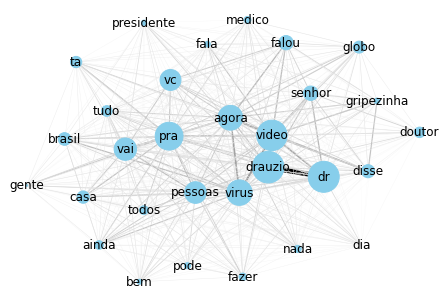

In [113]:
G = nx.Graph()

for i, row in enumerate(co_X):
    for j, co in enumerate(co_X[i]):
        G.add_edge(labels[i], labels[j], weight=(co))
        
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
norm_weights = (weights - min(weights)) / (max(weights) - min(weights))
norm_count = (comments_count - min(comments_count)) / (max(comments_count) - min(comments_count))

nx.draw(G, with_labels=True, node_color='skyblue', edgelist=edges, width=norm_weights*5, 
        edge_color=norm_weights, edge_cmap=cm.get_cmap('binary'), node_size=norm_count*1000)